# Observation Planning Part 3


1. Where is my target?
2. When can I observe my target?
3. How do I know when I've found my target (make a finder chart)?
4. How long do I need to observe?
5. __How will I calibrate my data?__


## How will I calibrate my data?

To make a photometric measurement, we need to know how efficient our instrument really is.  In theory, every photon collected in our telescope goes to the CCD and is converted to electrons, but in practice several factors prevent this.  What are the factors that limit our ability to collect the light?

(student answer)
 * Quantum Efficiency of detector
 * Scattering off internal telescope elements
 * Atmospheric absorption & scattering

To calibrate our image, we can use reference stars with known brightness to infer how much light is lost on the way to our image.

Landolt photometric standard stars are the best standards to use because they've been selected to be non-variable and have been carefully calibrated.  

However, the AAVSO (American Association of Variable Star Observers) has provided some really nice tools for obtaining standard star locations:

https://www.aavso.org/apps/vsd/stdfields

We can also retrieve catalogs from Vizier, the Centre de Données astronomiques de Strasbourg services for catalogs.

In [1]:
from astroquery.vizier import Vizier

You can use the `Vizier.get_catalogs` method in astroquery to grab the data from a catalog whose precise name you already know

In [2]:
Vizier.ROW_LIMIT = 10000
landolt_catalog = Vizier.get_catalogs('J/AJ/146/131/standards')

Vizier actually returns a list of tables:

In [3]:
landolt_catalog

TableList with 1 tables:
	'0:J/AJ/146/131/standards' with 16 column(s) and 349 row(s) 

But we want to look at only the first of these:

In [4]:
landolt_tbl = landolt_catalog[0]
landolt_tbl

Name,N,__Vmag_,__B-V_,__U-B_,__V-R_,__R-I_,__V-I_,No,Nn,RAJ2000,DEJ2000,_2MASS,pmRA,pmDE,SimbadName
,,mag,mag,mag,mag,mag,mag,,,"""h:m:s""","""d:m:s""",,mas / yr,mas / yr,
bytes12,bytes1,float32,float32,float32,float32,float32,float32,int16,int16,bytes12,bytes12,bytes17,float32,float32,bytes23
GD 2B,,13.279,0.588,-0.001,0.350,0.349,0.697,19,10,00 07 25.484,+33 19 00.17,J00072547+3319002,-9.6,-21.6,2MASS J00072547+3319002
GD 2A,,14.853,0.912,0.684,0.530,0.462,1.002,17,8,00 07 26.174,+33 18 19.18,J00072616+3318191,-17.3,-9.7,2MASS J00072616+3318191
GD 2,N,13.802,-0.295,-1.192,-0.142,-0.171,-0.313,26,13,00 07 32.261,+33 17 27.62,J00073225+3317275,-78.1,-66.7,2MASS J00073225+3317275
GD 2C,,13.314,0.619,0.081,0.360,0.357,0.718,17,8,00 07 32.355,+33 20 14.69,J00073235+3320147,-4.5,1.8,2MASS J00073235+3320147
GD 2E,,15.188,0.575,0.076,0.339,0.323,0.652,7,4,00 07 36.675,+33 17 41.73,J00073667+3317418,6.1,-0.2,2MASS J00073667+3317418
GD 2D,,14.255,0.605,0.007,0.355,0.370,0.729,9,5,00 07 41.634,+33 17 57.33,J00074163+3317573,-7.5,-5.9,2MASS J00074163+3317573
GD 410,N,12.845,0.725,0.086,0.441,0.438,0.879,1,1,00 35 24.704,+60 58 11.27,J00352470+6058113,109.1,42.1,2MASS J00352470+6058113
GD 8C,,13.299,0.636,0.140,0.371,0.358,0.724,14,7,00 39 37.145,+31 37 03.40,J00393714+3137034,-5.9,-11.5,2MASS J00393714+3137034


The table above contains two columns that specify the RA and Dec coordinates, `RAJ2000` and `DEJ2000`.


We'd like to be able to plot these and use them in some calculations below, so we'll turn them into `astropy.coordinates` objects.   Note that we need to do this because most software tools don't know how to read sexagesimal labels as numbers.  Anyway, the conversion process is easy:

In [5]:
from astropy import coordinates, units as u

In [6]:
landolt_coords = coordinates.SkyCoord(landolt_tbl['RAJ2000'], landolt_tbl['DEJ2000'], unit=(u.h, u.deg))

We can visualize the _sky coverage_ of these standard stars in RA and Dec:

In [7]:
import pylab as plt

Text(0, 0.5, 'Dec')

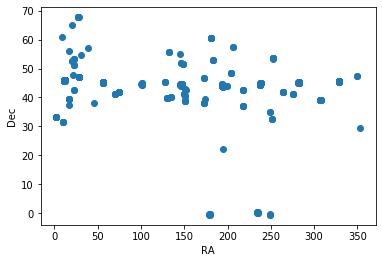

In [8]:
plt.plot(landolt_coords.ra, landolt_coords.dec, 'o')
plt.xlabel("RA")
plt.ylabel("Dec")

What if we want to figure out where these are in altitute and azimuth (alt/az) relative to us, the observer?  The Sky Plot feature from astroplan is good for that!  Of course, we need to specify the observatory first:

In [9]:
from astroplan import Observer
from astropy import units as u # shortcut
CTO = Observer(location=coordinates.EarthLocation(lat=29.643018, lon=-82.349004*u.deg, height=31*u.m),
               timezone='EST',
               name='University of Florida Campus Teaching Observatory',
              )


>>> from astroplan import download_IERS_A
>>> download_IERS_A()
 [astroplan.utils]


In [10]:
from astroplan.plots import plot_sky
from astropy.time import Time

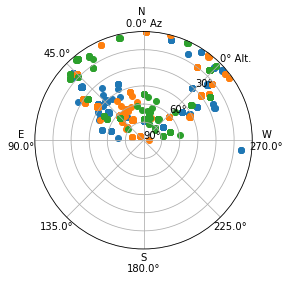

In [11]:
plot_sky(target=landolt_coords, observer=CTO, time=Time('2020-02-11 18:00:00'))
plot_sky(target=landolt_coords, observer=CTO, time=Time('2020-02-11 20:00:00'))
plot_sky(target=landolt_coords, observer=CTO, time=Time('2020-02-11 22:00:00'))

There are a lot of targets that go straight overhead!  There aren't so many in the South, but that's because we picked a standard star catalog that is meant for the north; if we wanted stars further south, we could use ["II/183A/table2"](http://vizier.u-strasbg.fr/viz-bin/VizieR-3?-source=II/183A/table2) instead.

Let's say we want to observe P Cygni.  How do we find the closest standard(s)?

First, we can simply overplot it on our RA/Dec plot

In [12]:
pcyg_coord = coordinates.SkyCoord.from_name('P Cygni')

Text(0, 0.5, 'Dec')

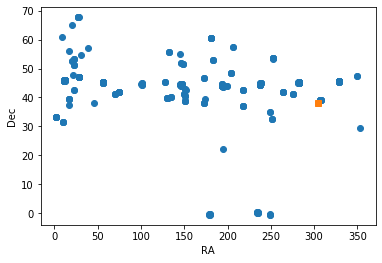

In [13]:
plt.plot(landolt_coords.ra, landolt_coords.dec, 'o')
plt.plot(pcyg_coord.ra, pcyg_coord.dec, 's')
plt.xlabel("RA")
plt.ylabel("Dec")

How can we figure out which calibrator source from the catalog is the closest one?

We can calculate the distance between P Cygni and each of the stars in the Landolt catalog.  That distance is the _angular separation_ on the sphere:
$$\theta = \cos^{-1} \left[ \sin(\delta_1) \sin(\delta_2) + \cos(\delta_1) \cos(\delta_2) \cos(\alpha_1 - \alpha_2) \right]$$

In practice, you don't want to do this yourself, as there can be numerical issues when calculating these values near the poles (see the article on [Great Circle distances](https://en.wikipedia.org/wiki/Great-circle_distance)).  Thankfully, astropy's coordinates provide a `separation` tool to calculate this for us.



In [14]:
distances_from_pcyg_to_standards = pcyg_coord.separation(landolt_coords)

We can then find which of these is closest by taking the minimum:

In [15]:
np.min(distances_from_pcyg_to_standards)

<Angle 2.62881701 deg>

The closest standard star is about 2 degrees away.  Which star is it, though?  We can use `np.argmin` to obtain the index corresponding to that minimum value.

In [16]:
index = np.argmin(distances_from_pcyg_to_standards)
index, landolt_coords[index]

(305, <SkyCoord (ICRS): (ra, dec) in deg
     (307.40492917, 39.28821667)>)

So now we have its location.  Can we find out more about the star, like its name and brightness?

Since `landolt_coords` has the same length and order as the `landolt_table` above, yes!  We can use the same index:

In [17]:
landolt_tbl[index]

Name,N,__Vmag_,__B-V_,__U-B_,__V-R_,__R-I_,__V-I_,No,Nn,RAJ2000,DEJ2000,_2MASS,pmRA,pmDE,SimbadName
,,mag,mag,mag,mag,mag,mag,,,"""h:m:s""","""d:m:s""",,mas / yr,mas / yr,
bytes12,bytes1,float32,float32,float32,float32,float32,float32,int16,int16,bytes12,bytes12,bytes17,float32,float32,bytes23
GD 391F,,12.500,0.544,0.048,0.329,0.331,0.660,10,5,20 29 37.183,+39 17 17.58,J20293718+3917176,-8.5,-15.4,2MASS J20293718+3917176


Great!  We've found our standard star, and we know it has a visual magnitude $V_{mag} = 12.5$!

In [18]:
print("V Magnitude of standard star: ",landolt_tbl[index]['__Vmag_'])

V Magnitude of standard star:  12.5


We can also determine its magnitude in the B and R bands using the colors in the table.  Note that the titles of the columns tell you what they contain: except for the V-band, the columns show _colors_, i.e., delta-magnitudes.  The `B-V` column is the `B-V` color.  If you want to obtain the B color, you just do `B-V + V = B`.  

In [19]:
print("B Magnitude of standard star: ",landolt_tbl[index]['__Vmag_'] + landolt_tbl[index]['__B-V_'])
print("R Magnitude of standard star: ",landolt_tbl[index]['__Vmag_'] - landolt_tbl[index]['__V-R_'])

B Magnitude of standard star:  13.044
R Magnitude of standard star:  12.171


Now that we've selected this star, we need to go back through and do the same planning exercises for it as for the targets:

1. Where is my calibrator?  (we answered this a few cells ago)
2. When can I observe my calibrator? (the same time as my target!)
3. How do I know when I've found my calibrator? (make a finder chart)
4. How long do I need to observe?

Since we've done (1) and (2), let's do (3) and (4):

Recall how you made finder charts from Observation Planning Exercise 1:

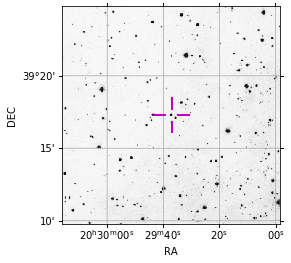

In [34]:
from astroplan.plots import plot_finder_image
ax, hdu = plot_finder_image(landolt_coords[index], survey='DSS', fov_radius=15*u.arcmin, grid=False, reticle=True)

If you've been on an observing run, you know that these finder charts are hard to use, and sometimes it's better to show them more saturated.  You can do that by specifying `style_kwargs`:

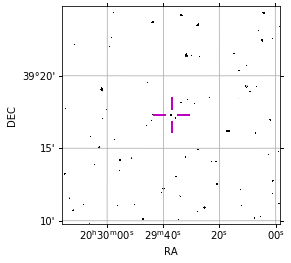

In [21]:
ax, hdu = plot_finder_image(landolt_coords[index], survey='DSS', fov_radius=15*u.arcmin, grid=False, reticle=True, style_kwargs={'vmin':18000, 'vmax':18100})

You can also change the colorscale if you want something that looks a little more like the night sky:

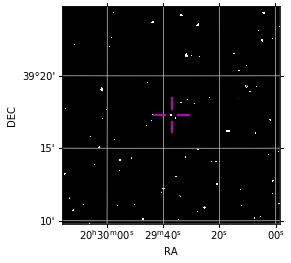

In [22]:
ax, hdu = plot_finder_image(landolt_coords[index], survey='DSS', fov_radius=15*u.arcmin, grid=False, reticle=True, style_kwargs={'vmin':18000, 'vmax':18100, 'cmap':'gray'})

How long do we need to observe?  We use the same technique as Observation Planning Exercise 2.

The zero points are:
* [3600 Jy for V-band](http://svo2.cab.inta-csic.es/theory/fps/index.php?id=Generic/Bessell.V&&mode=browse&gname=Generic&gname2=Bessell#filter)
* [4000 Jy for B-band](http://svo2.cab.inta-csic.es/theory/fps/index.php?id=Generic/Bessell.B&&mode=browse&gname=Generic&gname2=Bessell#filter)
* [2400 Jy for I-band](http://svo2.cab.inta-csic.es/theory/fps/index.php?id=Generic/Bessell.I&&mode=browse&gname=Generic&gname2=Bessell#filter)

In [23]:
standard_star_vmag = landolt_tbl[index]['__Vmag_']
vmag_zeropoint = 3600*u.Jy
snu_standard = vmag_zeropoint * (10**(-standard_star_vmag/2.5))
standard_star_vmag, snu_standard

(12.5, <Quantity 0.036 Jy>)

Using the telescope area and the filter properties, we now determine how much energy we receive from the star (which we calculated in the previous notebook):

* The V filter has a central wavelength of 5504 Angstroms
* The V filter has a width of "about" 1000 Angstroms (for [this filter](http://svo2.cab.inta-csic.es/theory/fps/index.php?id=Generic/Bessell.V&&mode=browse&gname=Generic&gname2=Bessell#filter), the width is 893 Angstroms, but we'll stick with the order-of-magnitude approximation for now)
* We are calculating the area of a 14-inch telescope

In [24]:
v_filt_wav = 5504*u.AA
v_filt_freq = (v_filt_wav).to(u.Hz, u.spectral())
v_filter_width = 1000*u.AA
A_CTO = (np.pi*(14/2 * u.imperial.inch)**2).to(u.cm**2)
standard_ergs_per_s = snu_standard * A_CTO * v_filt_freq*(v_filter_width/v_filt_wav)
standard_ergs_per_s.to(u.erg/u.s)

<Quantity 3.5381785e-08 erg / s>

In [25]:
from astropy import constants

As before, we want to know the _number of photons_ we will receive per second, so we convert the above energy to a photon rate.

In [26]:
standard_phot_per_s = (standard_ergs_per_s / (constants.h * v_filt_freq)).decompose()
standard_phot_per_s

<Quantity 9803.50629563 1 / s>

Then, we want to account for the inefficiences in our telescope: the average filter efficiency, the CCD's quantum efficiency, and the loss from atmospheric absorption (noting, of course, that the atmospheric loss is calculated for zenith, so it could be worse than this!)

In [27]:
filter_efficiency = 0.75
quantum_efficiency = 0.7
atmosphere_loss = 0.2
received_fraction = filter_efficiency * quantum_efficiency * (1-atmosphere_loss)
received_fraction

0.41999999999999993

As before, we need to determine how much our signal will be spread out.  We use the same $\sigma=2"$ PSF and $0.5"$ pixel scale

In [28]:
psf_area = 2 * np.pi * (2*u.arcsec)**2
psf_area

<Quantity 25.13274123 arcsec2>

In [29]:
pixel_scale = 0.5*u.arcsec/u.pixel
psf_area_pixels = psf_area * pixel_scale**-2
psf_area_pixels

<Quantity 100.53096491 pix2>

In [30]:
count_rate_per_pixel = standard_phot_per_s / psf_area_pixels * received_fraction
count_rate_per_pixel

<Quantity 40.95725777 1 / (pix2 s)>

We want our signal-to-noise ratio to be at least as good as our target, ideally better, since we will be comparing these measurements (taking their difference) and therefore their noise will add in quadrature again.  We can set a target SNR = 100 as before


In [31]:
readnoise_per_pix = 10*u.adu/u.pix
readnoise_sum = psf_area_pixels**0.5 * readnoise_per_pix
readnoise_sum

<Quantity 100.26513099 adu>

In [32]:
SNR = 100
target_signal = SNR**2 + (SNR**4 + 4*readnoise_sum.value*SNR**2)**0.5 / 2
target_signal

15099.279489285953

In [33]:
integration_time_including_readnoise = target_signal / standard_phot_per_s / received_fraction
integration_time_including_readnoise

<Quantity 3.66712321 s>

Now, repeat this exercise for:

* (1) the B and R filters.  How long do you need to expose the standard star in each of those filters to get to SNR = 100?
* (2) A standard star near your target.  You may pick the target you're using for the Observing Proposal (as you will need this information), or you can just pick something possibly interesting, like M33.



Note that for most of this exercise, you don't need to re-calculate much of the above.  Think about which items you do need to re-calculate.  Answer these questions before you do the exercise.

Do you need to recalculate or re-enter:

* The star's magnitude? Yes
* The star's spectral flux density?  Flux density?
* The star's count rate?
* The PSF area?
* The total readnoise?
* The telescope area?
* The filter center?
* The filter width?
* The goal SNR?
* The target signal for the goal SNR?
* The goal integration time?
* The star location?


Answer each of the above with a "Yes" or "No".  The first is answered "Yes" for you - we're looking at a different filter for part (1) and a different target for part (2), so you definitely need to have a different value for the magnitude.

Then, in new cells below here, complete the exercise: